## Time Accounting for the DDF Program
by Melissa Graham, 2021-11-08

#### 0. An accounting of the time spent so far (using the qcinv files)
The DDF has overspent a bit because ELAIS was used as a filler program early on and three extra sequences of DECaPS-East were done when they weren't requested. But overall, as of 2021-11-08, we're about on-course.

#### 1. Current version of DDF_fixed_scheduler_file.txt (created 2021-11-08)
The CURRENT version of DDF_fixed_scheduler_file.txt was created on 2021-11-08.
The difference from the OLD version is that the first four epochs on the COSMOS field were removed, in order to avoid an oversubscription problem caused by assuming 10 hour nights.

#### 2. OLD version of DDF_fixed_scheduler_file.txt (created at the start of 2021B)
The file OLD_DDF_fixed_scheduler_file.txt was created at the start of 2021B. It assumed 10 hours/night when the truth is 8.3 hours/night, and thus was oversubscribed.

In [1]:
import glob,os
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time

In [2]:
### To put a line for today on the plots below, define today's date.
today = '2021-11-08'
today_mjd = Time(today+'T00:00:00.00', format='isot', scale='utc').mjd

### 0. Show how much observing time the DDF has spent, to date

In [3]:
### Get the list of all the qcinv files to date
qcinv_fnms = glob.glob( '../../2021B/*/*.qcinv')

### Generate the list of dates and mjds
temp = []
for qfnm in qcinv_fnms:
    t1 = qfnm.split('/')[4]
    t2 = t1.split('.')[0]
    temp.append( t2[0:4]+'-'+t2[4:6]+'-'+t2[6:8] )
    del t1,t2
qcinv_dates = np.asarray( temp, dtype='str' )
del temp

temp = []
for qdate in qcinv_dates:
    temp.append( Time(qdate+'T00:00:00.00', format='isot', scale='utc').mjd )
qcinv_mjds = np.asarray( temp, dtype='float' )
del temp

In [4]:
### Generate arrays of the observations

### Set true if you want debugging output
verbose_level_1 = False
verbose_level_2 = False

temp1 = []
temp2 = []
temp3 = []
temp4 = []

for q,qfnm in enumerate(qcinv_fnms):
    f = open(qfnm)
    lines = f.readlines()
    last_target = 'other'
    start_time = '-:-'
    end_time = '-:-'
    for l,line in enumerate(lines):
        if (line[0:1] != '#'):

            ### Check if this line was a DDF observation
            tx_EL = line.find('ELAIS')
            tx_CO = line.find('COSMOS')
            tx_DE = line.find('DECaPS-East')
            tx_DW = line.find('DECaPS-West')
            if verbose_level_2 == True:
                print(last_target, tx_EL, tx_CO, tx_DE, tx_DW, start_time, end_time)

            ### If this line is a change in field, we now know the end time of a sequence
            if (line[0:1] != 'M') & (line[0:1] != 'p'):
                useline = line
            else:
                useline = lines[l-1] # this will only cause the loss of ~1 minute from accounting
            if (last_target == 'ELAIS') & (tx_EL < 0):
                end_time = useline.split()[3]
            if (last_target == 'COSMOS') & (tx_CO < 0):
                end_time = useline.split()[3]
            if (last_target == 'DECaPS-East') & (tx_DE < 0):
                end_time = useline.split()[3]
            if (last_target == 'DECaPS-West') & (tx_DW < 0):
                end_time = useline.split()[3]
            del useline

            ### If a sequence has ended, append it to our list of observations
            if end_time != '-:-':
                temp1.append(qcinv_dates[q])
                temp2.append(qcinv_mjds[q])
                temp3.append(last_target)
                start = float(start_time.split(':')[0]) + float(start_time.split(':')[1])/60.0
                end   = float(end_time.split(':')[0]) + float(end_time.split(':')[1])/60.0
                if start > 20.0:
                    start = start - 24.0
                if end > 20.0:
                    end = end - 24.0
                temp4.append( np.round( end - start, 3) )
                if verbose_level_1 == True:
                    print('seq end: ',qcinv_dates[q],qcinv_mjds[q],last_target,np.round( end - start, 3))
                start_time = '-:-'
                end_time = '-:-'
                del start, end

            ### If this sequence was the first on one of our fields, it's a new start time
            if (tx_EL >= 0) & (last_target != 'ELAIS'):
                start_time = line.split()[3]
            if (tx_CO >= 0) & (last_target != 'COSMOS'):
                start_time = line.split()[3]
            if (tx_DE >= 0) & (last_target != 'DECaPS-East'):
                start_time = line.split()[3]
            if (tx_DW >= 0) & (last_target != 'DECaPS-West'):
                start_time = line.split()[3]

            if tx_EL >= 0:
                last_target = 'ELAIS'
            if tx_CO >= 0:
                last_target = 'COSMOS'
            if tx_DE >= 0:
                last_target = 'DECaPS-East'
            if tx_DW >= 0:
                last_target = 'DECaPS-West'
            if (tx_EL < 0) & (tx_CO < 0) & (tx_DE < 0) & (tx_DW < 0):
                last_target = 'other'

            del tx_EL, tx_CO, tx_DE, tx_DW
    
    f.close()
    del f, lines, last_target, start_time, end_time

obs_date  = np.asarray( temp1, dtype='str' )
obs_mjd   = np.asarray( temp2, dtype='float' )
obs_fname = np.asarray( temp3, dtype='str' )
obs_dtime = np.asarray( temp4, dtype='float' )

del temp1,temp2,temp3,temp4
del verbose_level_1, verbose_level_2

In [5]:
### Generate a cumulative time
temp = []
for o,dtime in enumerate(obs_dtime):
    if o == 0:
        temp.append( dtime )
    else:
        temp.append( temp[o-1] + dtime )
obs_ctime = np.asarray( temp, dtype='float' )
del temp

In [6]:
### Print all sequences and their cumulative time in hours
for o,date in enumerate(obs_date):
    print('%10s  %7.1f  %11s  %5.2f  %5.2f' % (obs_date[o], obs_mjd[o], obs_fname[o], obs_dtime[o], obs_ctime[o]) )

2021-09-16  59473.0  DECaPS-East   1.17   1.17
2021-09-16  59473.0        ELAIS   1.07   2.23
2021-09-16  59473.0  DECaPS-West   0.40   2.63
2021-09-17  59474.0  DECaPS-West   0.53   3.17
2021-09-19  59476.0  DECaPS-East   0.58   3.75
2021-09-19  59476.0        ELAIS   1.67   5.42
2021-09-19  59476.0  DECaPS-West   0.53   5.95
2021-09-22  59479.0  DECaPS-East   1.10   7.05
2021-09-22  59479.0        ELAIS   1.97   9.02
2021-09-22  59479.0  DECaPS-West   0.42   9.43
2021-09-28  59485.0        ELAIS   1.02  10.45
2021-09-28  59485.0  DECaPS-West   0.70  11.15
2021-10-04  59491.0        ELAIS   1.03  12.18
2021-10-04  59491.0  DECaPS-West   0.42  12.60
2021-10-10  59497.0        ELAIS   1.05  13.65
2021-10-10  59497.0  DECaPS-West   0.55  14.20
2021-10-13  59500.0        ELAIS   1.02  15.22
2021-10-13  59500.0  DECaPS-West   0.38  15.60
2021-10-16  59503.0  DECaPS-East   0.55  16.15
2021-10-16  59503.0        ELAIS   1.05  17.20
2021-10-16  59503.0  DECaPS-West   0.55  17.75
2021-10-17  5

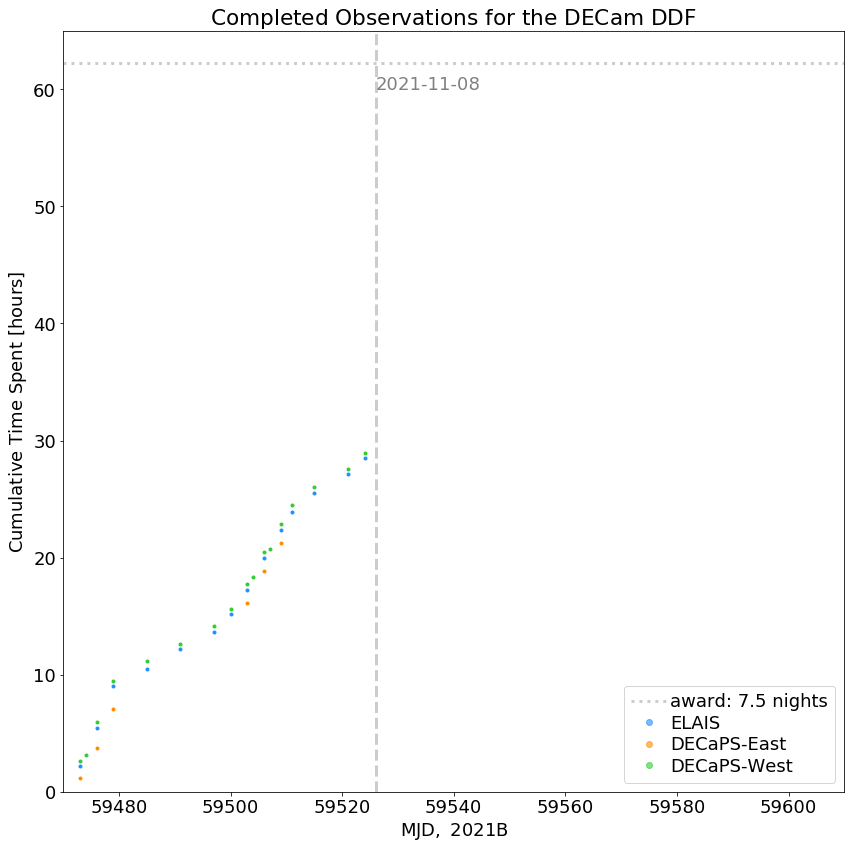

In [7]:
### Plot the cumulative time as a function of MJD over 2021B

fig = plt.figure(figsize=(14,14))
plt.rcParams.update({'font.size':18})

### horizontal line at the DDF time awarded
plt.axhline( 7.5*8.3, ls='dotted', lw=3, alpha=0.4, color='grey', label='award: 7.5 nights' )

### verticle line at "today"
plt.axvline( today_mjd, ls='dashed', lw=3, alpha=0.4, color='grey')
plt.text( today_mjd, 60, today, color='grey')

for o in range(len(obs_mjd)):
    if obs_fname[o] == 'ELAIS':
        point_color = 'dodgerblue'
    if obs_fname[o] == 'COSMOS':
        point_color = 'darkviolet'
    if obs_fname[o] == 'DECaPS-East':
        point_color = 'darkorange'
    if obs_fname[o] == 'DECaPS-West':
        point_color = 'limegreen'
    plt.plot( obs_mjd[o], obs_ctime[o], 'o', ms=3, alpha=1, color=point_color )

plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='dodgerblue', label='ELAIS' )
# plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='darkviolet', label='COSMOS' )
plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='darkorange', label='DECaPS-East' )
plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='limegreen', label='DECaPS-West' )
    
plt.xlim([59470,59610])
plt.ylim([0,65])
plt.xlabel(r'${\rm MJD,\ 2021B}$',fontsize=18)
plt.ylabel(r'${\rm Cumulative\ Time\ Spent\ [hours]}$',fontsize=18)
plt.title(r'${\rm Completed\ Observations\ for\ the\ DECam\ DDF}$')
plt.legend(loc='best',handletextpad=0.2,labelspacing=0.2,fontsize=18,numpoints=1,ncol=1)
plt.show()

#### The plot above...
... shows that using ELAIS (blue) as a filler program in those early full nights burned through our time, and DECaPS-East (orange) was done on three extra epochs when it wasn't in the observing plan (it was only supposed to be done on the first three full nights of the semester).

### 1. Show the plan for 2021B based on the current DDF fixed schedule file
"Current" version of DDF_fixed_scheduler_file.txt was made on 2021-11-08.

In [8]:
### Read in data from DDF_fixed_scheduler_file.txt
fsf_date  = np.loadtxt( 'DDF_fixed_scheduler_file.txt', dtype='str', usecols={0} )
fsf_seqid = np.loadtxt( 'DDF_fixed_scheduler_file.txt', dtype='str', usecols={1} )
fsf_dtime = np.loadtxt( 'DDF_fixed_scheduler_file.txt', dtype='float', usecols={4} )

### Grab just the field name from each of the sequence ids
temp = []
for fid in fsf_seqid:
    temp.append( fid.split('-')[0] )
fsf_fname = np.asarray( temp, dtype='str' )
del temp

### Convert the dates to MJD
temp = []
for fdate in fsf_date:
    temp.append( Time(fdate+'T00:00:00.00', format='isot', scale='utc').mjd )
fsf_mjd = np.asarray( temp, dtype='float' )
del temp

In [9]:
print( 'Total planned time is %5.2f hours' % np.sum(fsf_dtime) )
print( 'Assuming 8.3 hours a night, that is %4.2f nights.' % (np.sum(fsf_dtime)/8.3) )
print( 'And the DDF was awarded 7.5 nights.')

Total planned time is 62.88 hours
Assuming 8.3 hours a night, that is 7.58 nights.
And the DDF was awarded 7.5 nights.


In [10]:
### Generate array of cumulative time spent, if the plan is followed
temp = []
for f,fdt in enumerate(fsf_dtime):
    if f == 0:
        temp.append( fsf_dtime[f] )
    else:
        temp.append( temp[f-1]+fsf_dtime[f] )
fsf_dtimeC = np.asarray( temp, dtype='float' )
del temp

In [11]:
### Generate array of IDEAL cumulative time spent
###  which is the total time divided equally between epochs

### Generate array of unique dates (i.e., epochs)
udates = np.unique( fsf_date )
temp = []
for udate in udates:
    temp.append( Time(udate+'T00:00:00.00', format='isot', scale='utc').mjd )
udates_mjd = np.asarray( temp, dtype='float' )
del temp

### Calculate the ideal number of hours per night,
###  using 8.3 hours per night and the assigned 7.5 nights.
awarded_hours = 7.5 * 8.3
number_of_epochs = float( len(udates) )
ideal_hours_per_epoch = awarded_hours / number_of_epochs
str_ihpe = str( np.round(ideal_hours_per_epoch,1) )

### Generate the array of cumulative time spent, in the ideal case
temp = []
for u,udate in enumerate(udates):
    if u == 0:
        temp.append( ideal_hours_per_epoch )
    else:
        temp.append( temp[u-1] + ideal_hours_per_epoch )
udates_ideal_ctime = np.asarray( temp, dtype='float' )
del temp

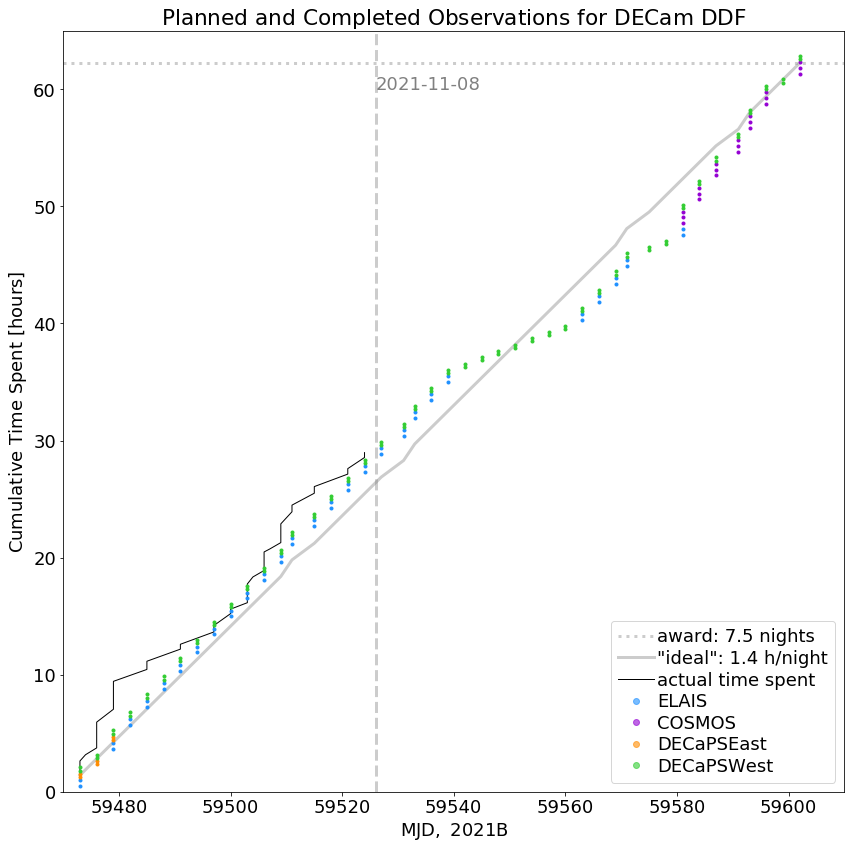

In [12]:
### Plot the cumulative time as a function of MJD over 2021B

fig = plt.figure(figsize=(14,14))
plt.rcParams.update({'font.size':18})

### horizontal line at the DDF time awarded
plt.axhline( 7.5*8.3, ls='dotted', lw=3, alpha=0.4, color='grey', label='award: 7.5 nights' )

### verticle line at "today"
plt.axvline( today_mjd, ls='dashed', lw=3, alpha=0.4, color='grey')
plt.text( today_mjd, 60, today, color='grey')

### plot the cumulative time if we divided the DDF time evenly over all nights
plt.plot( udates_mjd, udates_ideal_ctime, ls='solid', lw=3, alpha=0.4, color='grey', \
         label='"ideal": '+str_ihpe+' h/night')

### plot the actual cumulative time spent so far
plt.plot( obs_mjd, obs_ctime, lw=1, alpha=1, color='black', label='actual time spent')
# plt.plot( obs_mjd, obs_ctime, 'o', ms=2, alpha=1, color='black', label='actual time spent')

for f in range(len(fsf_mjd)):
    if fsf_fname[f] == 'ELAIS':
        point_color = 'dodgerblue'
    if fsf_fname[f] == 'COSMOS':
        point_color = 'darkviolet'
    if fsf_fname[f] == 'DECaPSEast':
        point_color = 'darkorange'
    if fsf_fname[f] == 'DECaPSWest':
        point_color = 'limegreen'
    plt.plot( fsf_mjd[f], fsf_dtimeC[f], 'o', ms=3, alpha=1, color=point_color )

plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='dodgerblue', label='ELAIS' )
plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='darkviolet', label='COSMOS' )
plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='darkorange', label='DECaPSEast' )
plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='limegreen', label='DECaPSWest' )
    
plt.xlim([59470,59610])
plt.ylim([0,65])
plt.xlabel(r'${\rm MJD,\ 2021B}$',fontsize=18)
plt.ylabel(r'${\rm Cumulative\ Time\ Spent\ [hours]}$',fontsize=18)
plt.title(r'${\rm Planned\ and\ Completed\ Observations\ for\ DECam\ DDF}$')
plt.legend(loc='best',handletextpad=0.2,labelspacing=0.2,fontsize=18,numpoints=1,ncol=1)
plt.show()

In [13]:
### Clean up
del fsf_date, fsf_seqid, fsf_dtime, fsf_fname, fsf_mjd, fsf_dtimeC
del udates, udates_mjd, udates_ideal_ctime
del awarded_hours, number_of_epochs, ideal_hours_per_epoch, str_ihpe

del obs_date, obs_mjd, obs_fname, obs_dtime, obs_ctime

### 2. Show how the OLD DDF fixed scheduler file would have over-spent for 2021B.
"OLD" version of DDF_fixed_scheduler_file.txt was made at the start of 2021B.

In [14]:
### Read in data from DDF_fixed_scheduler_file.txt
fsf_date  = np.loadtxt( 'OLD_DDF_fixed_scheduler_file.txt', dtype='str', usecols={0} )
fsf_seqid = np.loadtxt( 'OLD_DDF_fixed_scheduler_file.txt', dtype='str', usecols={1} )
fsf_dtime = np.loadtxt( 'OLD_DDF_fixed_scheduler_file.txt', dtype='float', usecols={4} )

### Grab just the field name from each of the sequence ids
temp = []
for fid in fsf_seqid:
    temp.append( fid.split('-')[0] )
fsf_fname = np.asarray( temp, dtype='str' )
del temp

### Convert the dates to MJD
temp = []
for fdate in fsf_date:
    temp.append( Time(fdate+'T00:00:00.00', format='isot', scale='utc').mjd )
fsf_mjd = np.asarray( temp, dtype='float' )
del temp

In [15]:
print( 'Total planned time is %5.2f hours' % np.sum(fsf_dtime) )
print( 'Assuming 10 hours a night, that is %4.2f nights.' % (np.sum(fsf_dtime)/10) )
print( 'But Alfredo said it is 8.3 hours a night, so %4.2f nights.' % (np.sum(fsf_dtime)/8.3) )
print( 'Thus the DDF is over-planned by %4.2f nights, or %4.2f hours.' % \
      ((np.sum(fsf_dtime)/8.3 - 7.5),8.3*(np.sum(fsf_dtime)/8.3 - 7.5)) )

Total planned time is 68.88 hours
Assuming 10 hours a night, that is 6.89 nights.
But Alfredo said it is 8.3 hours a night, so 8.30 nights.
Thus the DDF is over-planned by 0.80 nights, or 6.63 hours.


In [16]:
### Generate array of cumulative time spent, if the plan is followed
temp = []
for f,fdt in enumerate(fsf_dtime):
    if f == 0:
        temp.append( fsf_dtime[f] )
    else:
        temp.append( temp[f-1]+fsf_dtime[f] )
fsf_dtimeC = np.asarray( temp, dtype='float' )
del temp

In [17]:
### Generate array of IDEAL cumulative time spent
###  which is the total time divided equally between epochs

### Generate array of unique dates (i.e., epochs)
udates = np.unique( fsf_date )
temp = []
for udate in udates:
    temp.append( Time(udate+'T00:00:00.00', format='isot', scale='utc').mjd )
udates_mjd = np.asarray( temp, dtype='float' )
del temp

### Calculate the ideal number of hours per night,
###  using 8.3 hours per night and the assigned 7.5 nights.
awarded_hours = 7.5 * 8.3
number_of_epochs = float( len(udates) )
ideal_hours_per_epoch = awarded_hours / number_of_epochs
str_ihpe = str( np.round(ideal_hours_per_epoch,1) )

### Generate the array of cumulative time spent, in the ideal case
temp = []
for u,udate in enumerate(udates):
    if u == 0:
        temp.append( ideal_hours_per_epoch )
    else:
        temp.append( temp[u-1] + ideal_hours_per_epoch )
udates_ideal_ctime = np.asarray( temp, dtype='float' )
del temp

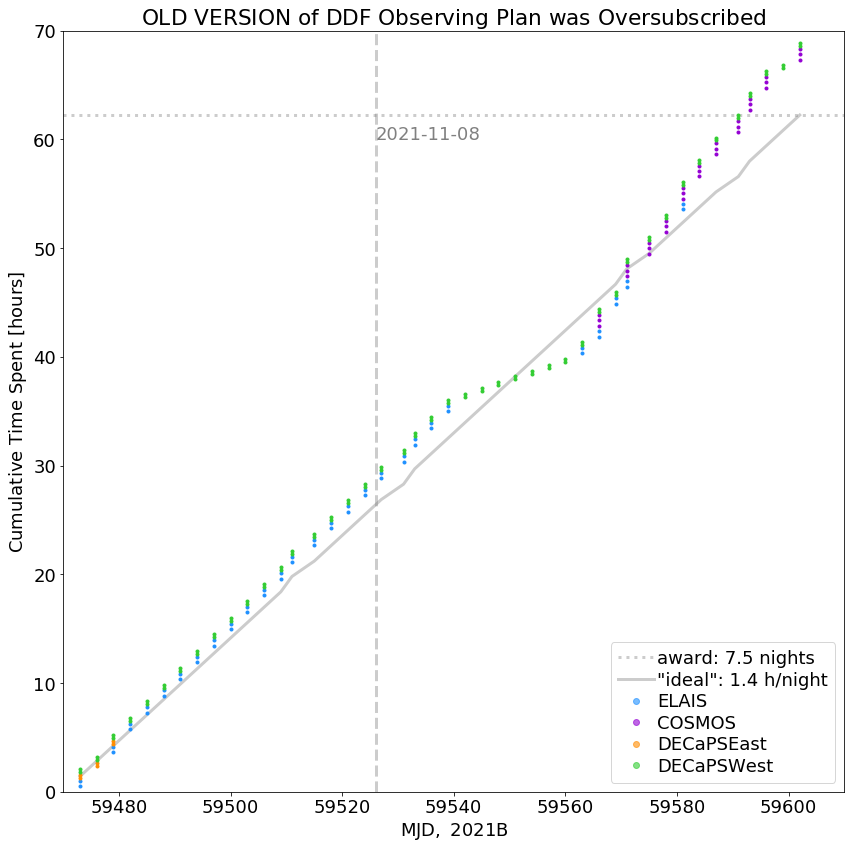

In [18]:
### Plot the cumulative time as a function of MJD over 2021B

fig = plt.figure(figsize=(14,14))
plt.rcParams.update({'font.size':18})

### horizontal line at the DDF time awarded
plt.axhline( 7.5*8.3, ls='dotted', lw=3, alpha=0.4, color='grey', label='award: 7.5 nights' )

### verticle line at "today"
plt.axvline( today_mjd, ls='dashed', lw=3, alpha=0.4, color='grey')
plt.text( today_mjd, 60, today, color='grey')

### plot the cumulative time if we divided the DDF time evenly over all nights
plt.plot( udates_mjd, udates_ideal_ctime, ls='solid', lw=3, alpha=0.4, color='grey', \
         label='"ideal": '+str_ihpe+' h/night')

for f in range(len(fsf_mjd)):
    if fsf_fname[f] == 'ELAIS':
        point_color = 'dodgerblue'
    if fsf_fname[f] == 'COSMOS':
        point_color = 'darkviolet'
    if fsf_fname[f] == 'DECaPSEast':
        point_color = 'darkorange'
    if fsf_fname[f] == 'DECaPSWest':
        point_color = 'limegreen'
    plt.plot( fsf_mjd[f], fsf_dtimeC[f], 'o', ms=3, alpha=1, color=point_color )

plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='dodgerblue', label='ELAIS' )
plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='darkviolet', label='COSMOS' )
plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='darkorange', label='DECaPSEast' )
plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='limegreen', label='DECaPSWest' )
    
plt.xlim([59470,59610])
plt.ylim([0,70])
plt.xlabel(r'${\rm MJD,\ 2021B}$',fontsize=18)
plt.ylabel(r'${\rm Cumulative\ Time\ Spent\ [hours]}$',fontsize=18)
plt.title(r'${\rm OLD\ VERSION\ of\ DDF\ Observing\ Plan\ was\ Oversubscribed}$')
plt.legend(loc='best',handletextpad=0.2,labelspacing=0.2,fontsize=18,numpoints=1,ncol=1)
plt.show()

The plot above shows that the COSMOS field was driving the DDF over the time awarded.

In [19]:
### Clean up
del fsf_date, fsf_seqid, fsf_dtime, fsf_fname, fsf_mjd, fsf_dtimeC
del udates, udates_mjd, udates_ideal_ctime
del awarded_hours, number_of_epochs, ideal_hours_per_epoch, str_ihpe